# CardioSense — Component 2: Cardiovascular Image Analysis (NIH ChestX-ray14)

This notebook trains a multi-label chest X-ray classifier on the **NIH ChestX-ray14** dataset using **KaggleHub** in **Google Colab**.

Dataset notes:
- 112,120 frontal-view chest X-ray PNG images from 30,805 patients.
- 14 disease labels per image (multi-label). The labels come from NLP on reports.
- Metadata file: `Data_Entry_2017.csv`
- Bounding boxes: `BBox_List_2017.csv` for ~1,000 images.
- Patient-level split files may be included: `train_val_list.txt`, `test_list.txt`.



In [ ]:

# ===== 1) Setup (Colab) =====
# Runtime -> Change runtime type -> GPU


!nvidia-smi -L


# Install KaggleHub + extras
!pip -q install -U kagglehub[pandas-datasets]


# PyTorch is preinstalled on Colab. Install torchmetrics and grad-cam helpers.
!pip -q install -U torchmetrics
!pip -q install -U grad-cam


import os
import re
import json
import math
import time
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights

from torchmetrics.classification import MultilabelAUROC

print("torch:", torch.__version__)


GPU 0: NVIDIA L4 (UUID: GPU-332c28b8-bc16-dc8f-b7be-fbf6cec6e0b1)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
torch: 2.9.0+cu126


In [ ]:

# ===== 2) Kaggle authentication =====
# Colab -> Secrets



import kagglehub


print("KaggleHub ready")


KaggleHub ready


In [ ]:

# ===== 3) Download dataset to Colab disk =====



DATASET_HANDLE = "nih-chest-xrays/data"

dataset_dir = Path(kagglehub.dataset_download(DATASET_HANDLE))
print("Dataset cached at:", dataset_dir)

# Show files
for p in sorted(dataset_dir.glob("*"))[:30]:
    print(p.name)


100%|██████████| 42.0G/42.0G [04:56<00:00, 152MB/s]


Extracting files...
Dataset cached at: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
ARXIV_V5_CHESTXRAY.pdf
BBox_List_2017.csv
Data_Entry_2017.csv
FAQ_CHESTXRAY.pdf
LOG_CHESTXRAY.pdf
README_CHESTXRAY.pdf
images_001
images_002
images_003
images_004
images_005
images_006
images_007
images_008
images_009
images_010
images_011
images_012
test_list.txt
train_val_list.txt


In [ ]:
# ===== 4) Extract images (first run only) =====



images_root = Path("/content/nih_cxr/images")
images_root.mkdir(parents=True, exist_ok=True)

tar_files_to_extract = sorted(dataset_dir.glob("images_*/images_*.tar.gz"))
print(f"Found {len(tar_files_to_extract)} tar.gz files to extract.")

def extract_tar_to(tar_path: Path, out_dir: Path) -> None:
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

# Count already extracted images in the final images_root (for restartability)
extracted_count_in_final_root = len(list(images_root.glob("*.png")))

if extracted_count_in_final_root > 0:
    print("Images already extracted to final destination:", extracted_count_in_final_root)
else:
    start = time.time()
    for i, tf in enumerate(tar_files_to_extract, 1):
        print(f"[{i}/{len(tar_files_to_extract)}] Extracting {tf.name} to {images_root} ...")
        extract_tar_to(tf, images_root)
    print(f"Done extracting tar.gz files in {round(time.time() - start, 1)} seconds.")

print("Total PNG files in final destination:", len(list(images_root.glob('*.png'))))


Found 0 tar.gz files to extract.
Done extracting tar.gz files in 0.0 seconds.
Total PNG files in final destination: 0


In [ ]:

# ===== 5) Load metadata =====

meta_path = dataset_dir / "Data_Entry_2017.csv"
bbox_path = dataset_dir / "BBox_List_2017.csv"

df = pd.read_csv(meta_path, engine="python")  # engine=python handles the trailing comma variants safely
# Drop unnamed blank columns if present
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

print("Metadata shape:", df.shape)
print(df.head())

# Keep only frontal views (PA/AP). Adjust if you want.
df = df[df["View Position"].isin(["PA", "AP"])].copy()
print("Frontal-only shape:", df.shape)

# 14 official labels
ALL_LABELS = [
    "Atelectasis","Cardiomegaly","Effusion","Infiltration","Mass","Nodule","Pneumonia",
    "Pneumothorax","Consolidation","Edema","Emphysema","Fibrosis","Pleural_Thickening","Hernia"
]

# Focus labels (cardio-related). You can switch to ALL_LABELS for full multi-label training.
TARGET_LABELS = ["Cardiomegaly", "Edema", "Effusion", "Infiltration"]

# Multi-hot encoding
labels_df = df["Finding Labels"].str.get_dummies(sep="|")
for col in ALL_LABELS:
    if col not in labels_df.columns:
        labels_df[col] = 0
labels_df = labels_df[ALL_LABELS].astype(np.float32)

# Choose label set
y = labels_df[TARGET_LABELS].values.astype(np.float32)

df["img_path"] = df["Image Index"].apply(lambda x: str(images_root / x))
missing = (~df["img_path"].apply(os.path.exists)).sum()
print("Missing image files:", int(missing))


Metadata shape: (112120, 11)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.1

In [12]:

# ===== 6) Patient-level split =====
# If the official split files exist, we use them.
# If not, we split by Patient ID to avoid leakage.

train_val_list = dataset_dir / "train_val_list.txt"
test_list = dataset_dir / "test_list.txt"

def read_list(path: Path):
    if not path.exists():
        return None
    with open(path, "r") as f:
        return [line.strip() for line in f if line.strip()]

train_imgs = read_list(train_val_list)
test_imgs = read_list(test_list)

if train_imgs is not None and test_imgs is not None:
    print("Using official split files.")
    is_test = df["Image Index"].isin(set(test_imgs))
    df_train = df[~is_test].copy()
    df_test = df[is_test].copy()
else:
    print("Split files not found. Creating patient-level split.")
    # Group split by Patient ID
    rng = np.random.default_rng(42)
    patients = df["Patient ID"].unique()
    rng.shuffle(patients)
    n_test = int(0.15 * len(patients))
    test_patients = set(patients[:n_test])
    is_test = df["Patient ID"].isin(test_patients)
    df_train = df[~is_test].copy()
    df_test = df[is_test].copy()

# Train/val split from train set by patient id
rng = np.random.default_rng(123)
train_patients = df_train["Patient ID"].unique()
rng.shuffle(train_patients)
n_val = int(0.15 * len(train_patients))
val_patients = set(train_patients[:n_val])

is_val = df_train["Patient ID"].isin(val_patients)
df_val = df_train[is_val].copy()
df_train = df_train[~is_val].copy()

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))

# Align y arrays for each split
def get_y(sub_df: pd.DataFrame) -> np.ndarray:
    idx = sub_df.index.to_numpy()
    return y[idx]

y_train = get_y(df_train)
y_val = get_y(df_val)
y_test = get_y(df_test)


Using official split files.
Train: 74064 Val: 12460 Test: 25596


In [ ]:

# ===== 7) PyTorch Dataset + Dataloaders =====

from PIL import Image

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df_subset: pd.DataFrame, y_subset: np.ndarray, tfms):
        self.df = df_subset.reset_index(drop=True)
        self.y = y_subset.astype(np.float32)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["img_path"]
        img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
        img = self.tfms(img)
        target = torch.from_numpy(self.y[i])
        return img, target, row["Image Index"]

train_ds = ChestXrayDataset(df_train, y_train, train_tfms)
val_ds   = ChestXrayDataset(df_val,   y_val,   eval_tfms)
test_ds  = ChestXrayDataset(df_test,  y_test,  eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))


Batches: 2315 390 800


In [14]:

# ===== 8) Model, loss, optimizer =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(TARGET_LABELS)

model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# Class imbalance handling: pos_weight
pos = y_train.sum(axis=0)
neg = len(y_train) - pos
pos_weight = torch.tensor(neg / (pos + 1e-6), dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

metric_auc = MultilabelAUROC(num_labels=num_classes, average=None).to(device)

print("pos_weight:", pos_weight.detach().cpu().numpy())


Device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 172MB/s]


pos_weight: [50.648537  61.082146   8.977637   5.2792706]


/tmp/ipython-input-311524544.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [15]:

# ===== 9) Train =====
EPOCHS = 3

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for imgs, targets, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits_np = torch.cat(all_logits).numpy()
    targets_np = torch.cat(all_targets).numpy()
    return avg_loss, logits_np, targets_np

best_val_auc = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_logits, tr_targets = run_epoch(train_loader, train=True)
    va_loss, va_logits, va_targets = run_epoch(val_loader, train=False)

    # AUROC per label
    with torch.no_grad():
        va_probs = torch.from_numpy(sigmoid_np(va_logits)).to(device)
        va_t = torch.from_numpy(va_targets).to(device)
        aucs = metric_auc(va_probs, va_t).detach().cpu().numpy()

    macro_auc = float(np.nanmean(aucs))
    sec = round(time.time() - t0, 1)

    scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "val_auc_macro": macro_auc,
        "seconds": sec,
    }
    for i, lab in enumerate(TARGET_LABELS):
        row[f"val_auc_{lab}"] = float(aucs[i])

    history.append(row)

    print(json.dumps(row, indent=2))

    # Save best
    if macro_auc > best_val_auc:
        best_val_auc = macro_auc
        Path("outputs").mkdir(exist_ok=True)
        torch.save(model.state_dict(), "outputs/cardiosense_cxr_densenet121.pth")
        with open("outputs/label_map.json", "w") as f:
            json.dump({"labels": TARGET_LABELS}, f, indent=2)

pd.DataFrame(history).to_csv("outputs/train_history.csv", index=False)
print("Best val macro AUC:", best_val_auc)


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-3944540698.py", line 36, in __getitem__
    img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
          ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3513, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/nih_cxr/images/00018044_012.png'


In [ ]:

# ===== 10) Evaluate on test =====
# Load best weights

model.load_state_dict(torch.load("outputs/cardiosense_cxr_densenet121.pth", map_location=device))
model.eval()

te_loss, te_logits, te_targets = run_epoch(test_loader, train=False)

with torch.no_grad():
    te_probs = torch.from_numpy(sigmoid_np(te_logits)).to(device)
    te_t = torch.from_numpy(te_targets).to(device)
    aucs = metric_auc(te_probs, te_t).detach().cpu().numpy()

print("Test loss:", te_loss)
for i, lab in enumerate(TARGET_LABELS):
    print(lab, "AUROC:", float(aucs[i]))
print("Macro AUROC:", float(np.nanmean(aucs)))


In [ ]:

# ===== 11) Grad-CAM (one example) =====
# This shows which regions influenced the prediction.
# You can swap the target label index.

!pip -q install -U opencv-python

import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Pick a single sample from the test set
img, target, img_name = test_ds[0]
input_tensor = img.unsqueeze(0).to(device)

# DenseNet target layer: last dense block
target_layers = [model.features.denseblock4]

cam = GradCAM(model=model, target_layers=target_layers)

target_label_idx = 0  # 0 -> TARGET_LABELS[0]
targets = [ClassifierOutputTarget(target_label_idx)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # HxW

# Convert the normalized tensor back to RGB for overlay
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                               DenseNet121_Weights.IMAGENET1K_V1.transforms().std)],
    std=[1/s for s in DenseNet121_Weights.IMAGENET1K_V1.transforms().std],
)
rgb = inv_norm(img).clamp(0, 1).permute(1, 2, 0).cpu().numpy()

overlay = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

Path("outputs").mkdir(exist_ok=True)
out_path = "outputs/gradcam_example.png"
cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(6, 6))
plt.title(f"{img_name} | {TARGET_LABELS[target_label_idx]}")
plt.imshow(overlay)
plt.axis("off")
plt.show()

print("Saved:", out_path)


In [ ]:

# ===== 12) Export artifacts (zip + download) =====
# This zips the trained model + logs + label map.
# It does not include the full NIH image dataset (too large).

from google.colab import files
import zipfile

zip_name = "CardioSense_Component2_Artifacts.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    for p in Path("outputs").glob("*"):
        z.write(p, arcname=f"outputs/{p.name}")

print("Created:", zip_name)
files.download(zip_name)


In [ ]:
# ===== 4) Extract images (first run only) =====


images_root = Path("/content/nih_cxr/images")
images_root.mkdir(parents=True, exist_ok=True)



images_001_path = dataset_dir / "images_001"
print(f"Contents of {images_001_path}:")
!ls -l {images_001_path}


tar_files_to_extract = sorted(dataset_dir.glob("images_*/images_*.tar.gz"))
print(f"Found {len(tar_files_to_extract)} tar.gz files to extract.")

def extract_tar_to(tar_path: Path, out_dir: Path) -> None:
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

# Count already extracted images in the final images_root (for restartability)
extracted_count_in_final_root = len(list(images_root.glob("*.png")))

if extracted_count_in_final_root > 0:
    print("Images already extracted to final destination:", extracted_count_in_final_root)
else:
    start = time.time()
    for i, tf in enumerate(tar_files_to_extract, 1):
        print(f"[{i}/{len(tar_files_to_extract)}] Extracting {tf.name} to {images_root} ...")
        extract_tar_to(tf, images_root)
    print(f"Done extracting tar.gz files in {round(time.time() - start, 1)} seconds.")

print("Total PNG files in final destination:", len(list(images_root.glob('*.png'))))


In [ ]:
# ===== 4) Consolidate Image Paths =====
# The dataset contains images extracted by KaggleHub into nested subdirectories.

image_subdirs = []
for i in range(1, 13): # Assuming images_001 to images_012
    subdir_path = dataset_dir / f"images_{i:03d}" / "images"
    if subdir_path.is_dir():
        image_subdirs.append(subdir_path)

print(f"Found {len(image_subdirs)} image subdirectories.")

# Build a dictionary mapping image filename to its full path
image_name_to_path = {}
start_scan = time.time()
for i, subdir in enumerate(image_subdirs):
    print(f"Scanning [{i+1}/{len(image_subdirs)}] {subdir}...")
    for img_path in subdir.glob("*.png"):
        image_name_to_path[img_path.name] = str(img_path)

print(f"Scanned {len(image_name_to_path)} image files in {round(time.time() - start_scan, 1)} seconds.")

images_root = Path("/content/nih_cxr/images") 


In [ ]:
# ===== 5) Load metadata and Consolidate Image Paths =====
meta_path = dataset_dir / "Data_Entry_2017.csv"
bbox_path = dataset_dir / "BBox_List_2017.csv"

df = pd.read_csv(meta_path, engine="python")  # engine=python handles the trailing comma variants safely
# Drop unnamed blank columns if present
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

print("Metadata shape:", df.shape)
print(df.head())

# Keep only frontal views (PA/AP). Adjust if you want.
df = df[df["View Position"].isin(["PA", "AP"])].copy()
print("Frontal-only shape:", df.shape)

# 14 official labels
ALL_LABELS = [
    "Atelectasis","Cardiomegaly","Effusion","Infiltration","Mass","Nodule","Pneumonia",
    "Pneumothorax","Consolidation","Edema","Emphysema","Fibrosis","Pleural_Thickening","Hernia"
]

# Focus labels (cardio-related). You can switch to ALL_LABELS for full multi-label training.
TARGET_LABELS = ["Cardiomegaly", "Edema", "Effusion", "Infiltration"]

# Multi-hot encoding
labels_df = df["Finding Labels"].str.get_dummies(sep="|")
for col in ALL_LABELS:
    if col not in labels_df.columns:
        labels_df[col] = 0
labels_df = labels_df[ALL_LABELS].astype(np.float32)

# Choose label set
y = labels_df[TARGET_LABELS].values.astype(np.float32)

# === Consolidate Image Paths 

image_subdirs = []
for i in range(1, 13): # Assuming images_001 to images_012
    subdir_path = dataset_dir / f"images_{i:03d}" / "images"
    if subdir_path.is_dir():
        image_subdirs.append(subdir_path)

print(f"Found {len(image_subdirs)} image subdirectories.")

image_name_to_path = {}
start_scan = time.time()
for i, subdir in enumerate(image_subdirs):
    print(f"Scanning [{i+1}/{len(image_subdirs)}] {subdir}...")
    for img_path in subdir.glob("*.png"):
        image_name_to_path[img_path.name] = str(img_path)

print(f"Scanned {len(image_name_to_path)} image files in {round(time.time() - start_scan, 1)} seconds.")

# === Update df["img_path"] ===
df["img_path"] = df["Image Index"].apply(lambda x: image_name_to_path.get(x, ""))
# Check for images that are still missing
missing = (~df["img_path"].apply(os.path.exists)).sum()
print("Missing image files:", int(missing))


Metadata shape: (112120, 11)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.1

In [18]:
# ===== 9) Train =====
EPOCHS = 3  # set higher for better results

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for imgs, targets, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits_np = torch.cat(all_logits).numpy()
    targets_np = torch.cat(all_targets).numpy()
    return avg_loss, logits_np, targets_np

best_val_auc = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_logits, tr_targets = run_epoch(train_loader, train=True)
    va_loss, va_logits, va_targets = run_epoch(val_loader, train=False)

    # AUROC per label
    with torch.no_grad():
        va_probs = torch.from_numpy(sigmoid_np(va_logits)).to(device)
        va_t = torch.from_numpy(va_targets).to(device)
        aucs = metric_auc(va_probs, va_t).detach().cpu().numpy()

    macro_auc = float(np.nanmean(aucs))
    sec = round(time.time() - t0, 1)

    scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "val_auc_macro": macro_auc,
        "seconds": sec,
    }
    for i, lab in enumerate(TARGET_LABELS):
        row[f"val_auc_{lab}"] = float(aucs[i])

    history.append(row)

    print(json.dumps(row, indent=2))

    # Save best
    if macro_auc > best_val_auc:
        best_val_auc = macro_auc
        Path("outputs").mkdir(exist_ok=True)
        torch.save(model.state_dict(), "outputs/cardiosense_cxr_densenet121.pth")
        with open("outputs/label_map.json", "w") as f:
            json.dump({"labels": TARGET_LABELS}, f, indent=2)

pd.DataFrame(history).to_csv("outputs/train_history.csv", index=False)
print("Best val macro AUC:", best_val_auc)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-3944540698.py", line 36, in __getitem__
    img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
          ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3513, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/nih_cxr/images/00027334_007.png'


In [ ]:
# ===== 7) PyTorch Dataset + Dataloaders =====
from PIL import Image

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0 # Changed to 0 to debug DataLoader worker file access issues

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGEN1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGEN1K_V1.transforms().std),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df_subset: pd.DataFrame, y_subset: np.ndarray, tfms):
        self.df = df_subset.reset_index(drop=True)
        self.y = y_subset.astype(np.float32)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["img_path"]
        img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
        img = self.tfms(img)
        target = torch.from_numpy(self.y[i])
        return img, target, row["Image Index"]

train_ds = ChestXrayDataset(df_train, y_train, train_tfms)
val_ds   = ChestXrayDataset(df_val,   y_val,   eval_tfms)
test_ds  = ChestXrayDataset(df_test,  y_test,  eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))

In [21]:
# ===== 7) PyTorch Dataset + Dataloaders =====
from PIL import Image

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0 # Changed to 0 to debug DataLoader worker file access issues

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df_subset: pd.DataFrame, y_subset: np.ndarray, tfms):
        self.df = df_subset.reset_index(drop=True)
        self.y = y_subset.astype(np.float32)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["img_path"]
        # DEBUG: Print the path being accessed
        print(f"Attempting to open: {path}")
        img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
        img = self.tfms(img)
        target = torch.from_numpy(self.y[i])
        return img, target, row["Image Index"]

train_ds = ChestXrayDataset(df_train, y_train, train_tfms)
val_ds   = ChestXrayDataset(df_val,   y_val,   eval_tfms)
test_ds  = ChestXrayDataset(df_test,  y_test,  eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))


Batches: 2315 390 800


In [22]:
# ===== 9) Train =====
EPOCHS = 3  # set higher for better results

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for imgs, targets, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits_np = torch.cat(all_logits).numpy()
    targets_np = torch.cat(all_targets).numpy()
    return avg_loss, logits_np, targets_np

best_val_auc = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_logits, tr_targets = run_epoch(train_loader, train=True)
    va_loss, va_logits, va_targets = run_epoch(val_loader, train=False)

    # AUROC per label
    with torch.no_grad():
        va_probs = torch.from_numpy(sigmoid_np(va_logits)).to(device)
        va_t = torch.from_numpy(va_targets).to(device)
        aucs = metric_auc(va_probs, va_t).detach().cpu().numpy()

    macro_auc = float(np.nanmean(aucs))
    sec = round(time.time() - t0, 1)

    scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "val_auc_macro": macro_auc,
        "seconds": sec
    }
    for i, lab in enumerate(TARGET_LABELS):
        row[f"val_auc_{lab}"] = float(aucs[i])

    history.append(row)

    print(json.dumps(row, indent=2))

    # Save best
    if macro_auc > best_val_auc:
        best_val_auc = macro_auc
        Path("outputs").mkdir(exist_ok=True)
        torch.save(model.state_dict(), "outputs/cardiosense_cxr_densenet121.pth")
        with open("outputs/label_map.json", "w") as f:
            json.dump({"labels": TARGET_LABELS}, f, indent=2)

pd.DataFrame(history).to_csv("outputs/train_history.csv", index=False)
print("Best val macro AUC:", best_val_auc)

Attempting to open: /content/nih_cxr/images/00020325_000.png


FileNotFoundError: [Errno 2] No such file or directory: '/content/nih_cxr/images/00020325_000.png'

In [ ]:
# ===== 6) Patient-level split =====


train_val_list = dataset_dir / "train_val_list.txt"
test_list = dataset_dir / "test_list.txt"

def read_list(path: Path):
    if not path.exists():
        return None
    with open(path, "r") as f:
        return [line.strip() for line in f if line.strip()]

train_imgs = read_list(train_val_list)
test_imgs = read_list(test_list)

if train_imgs is not None and test_imgs is not None:
    print("Using official split files.")
    is_test = df["Image Index"].isin(set(test_imgs))
    df_train = df[~is_test].copy()
    df_test = df[is_test].copy()
else:
    print("Split files not found. Creating patient-level split.")
    # Group split by Patient ID
    rng = np.random.default_rng(42)
    patients = df["Patient ID"].unique()
    rng.shuffle(patients)
    n_test = int(0.15 * len(patients))
    test_patients = set(patients[:n_test])
    is_test = df["Patient ID"].isin(test_patients)
    df_train = df[~is_test].copy()
    df_test = df[is_test].copy()

# Train/val split from train set by patient id
rng = np.random.default_rng(123)
train_patients = df_train["Patient ID"].unique()
rng.shuffle(train_patients)
n_val = int(0.15 * len(train_patients))
val_patients = set(train_patients[:n_val])

is_val = df_train["Patient ID"].isin(val_patients)
df_val = df_train[is_val].copy()
df_train = df_train[~is_val].copy()

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))

# Align y arrays for each split
def get_y(sub_df: pd.DataFrame) -> np.ndarray:
    idx = sub_df.index.to_numpy()
    return y[idx]

y_train = get_y(df_train)
y_val = get_y(df_val)
y_test = get_y(df_test)


In [ ]:
# ===== 7) PyTorch Dataset + Dataloaders =====
from PIL import Image

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0 # Changed to 0 to debug DataLoader worker file access issues

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DenseNet121_Weights.IMAGENET1K_V1.transforms().mean,
                         std=DenseNet121_Weights.IMAGENET1K_V1.transforms().std),
])

class ChestXrayDataset(Dataset):
    def __init__(self, df_subset: pd.DataFrame, y_subset: np.ndarray, tfms):
        self.df = df_subset.reset_index(drop=True)
        self.y = y_subset.astype(np.float32)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["img_path"]
        img = Image.open(path).convert("RGB")  # DenseNet expects 3-ch
        img = self.tfms(img)
        target = torch.from_numpy(self.y[i])
        return img, target, row["Image Index"]

train_ds = ChestXrayDataset(df_train, y_train, train_tfms)
val_ds   = ChestXrayDataset(df_val,   y_val,   eval_tfms)
test_ds  = ChestXrayDataset(df_test,  y_test,  eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Batches:", len(train_loader), len(val_loader), len(test_loader))

In [ ]:
# ===== 9) Train =====
EPOCHS = 3  # set higher for better results

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for imgs, targets, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits_np = torch.cat(all_logits).numpy()
    targets_np = torch.cat(all_targets).numpy()
    return avg_loss, logits_np, targets_np

best_val_auc = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_logits, tr_targets = run_epoch(train_loader, train=True)
    va_loss, va_logits, va_targets = run_epoch(val_loader, train=False)

    # AUROC per label
    with torch.no_grad():
        va_probs = torch.from_numpy(sigmoid_np(va_logits)).to(device)
        va_t = torch.from_numpy(va_targets).to(device)
        aucs = metric_auc(va_probs, va_t).detach().cpu().numpy()

    macro_auc = float(np.nanmean(aucs))
    sec = round(time.time() - t0, 1)

    scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "val_auc_macro": macro_auc,
        "seconds": sec
    }
    for i, lab in enumerate(TARGET_LABELS):
        row[f"val_auc_{lab}"] = float(aucs[i])

    history.append(row)

    print(json.dumps(row, indent=2))

    # Save best
    if macro_auc > best_val_auc:
        best_val_auc = macro_auc
        Path("outputs").mkdir(exist_ok=True)
        torch.save(model.state_dict(), "outputs/cardiosense_cxr_densenet121.pth")
        with open("outputs/label_map.json", "w") as f:
            json.dump({"labels": TARGET_LABELS}, f, indent=2)

pd.DataFrame(history).to_csv("outputs/train_history.csv", index=False)
print("Best val macro AUC:", best_val_auc)

In [26]:
# ===== 9) Train =====
EPOCHS = 3  # set higher for better results

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_logits = []
    all_targets = []

    for imgs, targets, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * imgs.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = total_loss / len(loader.dataset)
    logits_np = torch.cat(all_logits).numpy()
    targets_np = torch.cat(all_targets).numpy()
    return avg_loss, logits_np, targets_np

best_val_auc = -1.0
history = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_logits, tr_targets = run_epoch(train_loader, train=True)
    va_loss, va_logits, va_targets = run_epoch(val_loader, train=False)

    # AUROC per label
    with torch.no_grad():
        va_probs = torch.from_numpy(sigmoid_np(va_logits)).to(device)
        va_t = torch.from_numpy(va_targets).to(device).long() # Cast targets to long
        aucs = metric_auc(va_probs, va_t).detach().cpu().numpy()

    macro_auc = float(np.nanmean(aucs))
    sec = round(time.time() - t0, 1)

    scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": tr_loss,
        "val_loss": va_loss,
        "val_auc_macro": macro_auc,
        "seconds": sec
    }
    for i, lab in enumerate(TARGET_LABELS):
        row[f"val_auc_{lab}"] = float(aucs[i])

    history.append(row)

    print(json.dumps(row, indent=2))

    # Save best
    if macro_auc > best_val_auc:
        best_val_auc = macro_auc
        Path("outputs").mkdir(exist_ok=True)
        torch.save(model.state_dict(), "outputs/cardiosense_cxr_densenet121.pth")
        with open("outputs/label_map.json", "w") as f:
            json.dump({"labels": TARGET_LABELS}, f, indent=2)

pd.DataFrame(history).to_csv("outputs/train_history.csv", index=False)
print("Best val macro AUC:", best_val_auc)


/tmp/ipython-input-1946156923.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{
  "epoch": 1,
  "train_loss": 0.9670512889213916,
  "val_loss": 0.8999162214142936,
  "val_auc_macro": 0.8304840922355652,
  "seconds": 2137.4,
  "val_auc_Cardiomegaly": 0.8794779777526855,
  "val_auc_Edema": 0.8918595314025879,
  "val_auc_Effusion": 0.8744581341743469,
  "val_auc_Infiltration": 0.6761407852172852
}
{
  "epoch": 2,
  "train_loss": 0.8736386717743584,
  "val_loss": 0.8958874335449734,
  "val_auc_macro": 0.8368078470230103,
  "seconds": 2106.2,
  "val_auc_Cardiomegaly": 0.8979874849319458,
  "val_auc_Edema": 0.8924921154975891,
  "val_auc_Effusion": 0.8792350888252258,
  "val_auc_Infiltration": 0.6775168180465698
}


/tmp/ipython-input-1946156923.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1946156923.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


KeyboardInterrupt: 

Please upload a chest X-ray image (PNG or JPG)...


Saving images (11).jpeg to images (11).jpeg
Processing images (11).jpeg...


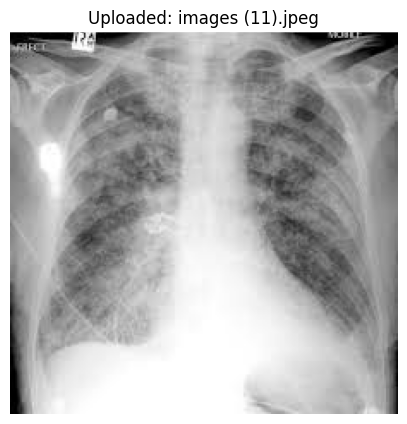

Predictions:
  Cardiomegaly   : 17.81%
  Edema          : 22.49%
  Effusion       : 70.53%
  Infiltration   : 68.36%
------------------------------


In [29]:
# ===== Test with User Upload =====
from google.colab import files
import matplotlib.pyplot as plt

# 1. Upload image
print("Please upload a chest X-ray image (PNG or JPG)...")
uploaded = files.upload()

model.eval()

# 2. Process and Predict
for filename in uploaded.keys():
    print(f"Processing {filename}...")

    # Open image
    try:
        img = Image.open(filename).convert("RGB")
    except Exception as e:
        print(f"Error opening {filename}: {e}")
        continue

    # Preprocess
    input_tensor = eval_tfms(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    # Show Image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Uploaded: {filename}")
    plt.show()

    # Print Predictions
    print("Predictions:")
    for label, prob in zip(TARGET_LABELS, probs):
        print(f"  {label:15s}: {prob:.2%}")
    print("-" * 30)


In [30]:
import shutil
from google.colab import files

# Zip the 'outputs' directory containing the model and logs
zip_filename = 'cardiosense_model_outputs'
shutil.make_archive(zip_filename, 'zip', 'outputs')

print(f"Zipped outputs to {zip_filename}.zip")
print("Triggering download... (If it doesn't start, check your browser's pop-up blocker)")

# Trigger download
files.download(f'{zip_filename}.zip')

print("To download this notebook, please go to: File -> Download -> Download .ipynb")

Zipped outputs to cardiosense_model_outputs.zip
Triggering download... (If it doesn't start, check your browser's pop-up blocker)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To download this notebook, please go to: File -> Download -> Download .ipynb
